# Datenanalyse


---

Datensatz: [Synthea Breast Cancer Dataset](https://github.com/Fuenfgeld/DMA2023TeamA/tree/main/Daten/Quelldaten)

Primär- und Fremdschlüsseldefinitionen: [Synthea GitHub Repository](https://github.com/synthetichealth/synthea/wiki/CSV-File-Data-Dictionary)

Projektgruppe GitHub Repository: [DMA2023TeamA](https://github.com/Fuenfgeld/DMA2023TeamA)

Source-DB: [GoogleDrive Ablage](https://drive.google.com/drive/folders/1k5cfjGXjNHmwQkydzjTdVHoBvCniBU_W), erstellt mit [Setup_and_fill_Database.ipynb](https://github.com/Fuenfgeld/DMA2023TeamA/blob/main/Code/Setup_and_fill_Database.ipynb)

Data Warehouse-Datenbank: [GoogleDrive Ablage](https://drive.google.com/file/d/1l-HcqCezubHnR737DkbiRzdHanP7_g_D), erstellt mit [ETL_process.ipynb](https://github.com/Fuenfgeld/DMA2023TeamA/blob/main/Code/ETL_Process.ipynb)


*Version*: 1.0

Version Date: 12/02/2023

Changes: 

**0.2**
* Erstellung eines Analysedatensatzes aus den aus der DWH-Datenbank extrahierten Daten (Gesamtkosten für Aufenthalte / Prozeduren / Medikationen pro Patient)
* Ergänzung Versionsnummern für neue Pakete

**1.0**
* Explorative Datenanalyse (EDA)
* Machine Learning Ansätze


# Vorbereitung des Notebooks

In [1]:
# Vorsichtshalber: Löschen aller Variablen
%reset -f

# Laden der benötigten Libraries
from google.colab import drive
import sqlite3 as sq
from sqlite3 import Error
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport
# will make plot outputs appear and stored within the notebook.
%matplotlib inline

In [2]:
# Google Drive mounten, force_remount auf True setzen, damit ein Remount erzwungen wird
drive.mount('/content/gdrive/', force_remount=True)

# Datenbankordner auf dem Shareddrive checken, es müssen source_breast_cancer.db und DWH_breast_cancer.db vorhanden sein
!ls "/content/gdrive/Shareddrives/DMA_Datenprojekt_TeamA/Daten/Datenbank"

# Patiententyp festlegen
patient_type = "breast_cancer"

# Pfad zur DWH-Datenbank setzen
DB_DWH_PATH = "/content/gdrive/Shareddrives/DMA_Datenprojekt_TeamA/Daten/Datenbank/DWH_breast_cancer.db"

# Pfad zum Analyse-Datensatz setzen
DATA_PATH = "/content/gdrive/Shareddrives/DMA_Datenprojekt_TeamA/Daten/Analyse/"

# Pfad zum Ergebnisordner setzen
RESULTS_PATH = "/content/gdrive/Shareddrives/DMA_Datenprojekt_TeamA/Ergebnisse/"

# Check
print("\n" + DB_DWH_PATH)
print("\n" + DATA_PATH)
print("\n" + RESULTS_PATH)

Mounted at /content/gdrive/
DWH_breast_cancer.db  source_breast_cancer.db  TEST_DWH_breast_cancer.db

/content/gdrive/Shareddrives/DMA_Datenprojekt_TeamA/Daten/Datenbank/DWH_breast_cancer.db

/content/gdrive/Shareddrives/DMA_Datenprojekt_TeamA/Daten/Analyse/

/content/gdrive/Shareddrives/DMA_Datenprojekt_TeamA/Ergebnisse/


# Versionen der verwendeten Pakete abfragen 

Die Versionen der verwendeten Python-Installation und der Python-Pakete abfragen. 

In [3]:
# Python-Version
print("Python-Version:")
!python --version

# Pandas-Version
print("\n" + "Pandas-Version:")
print("Pandas " + pd.__version__)

# numpy-Version
print("\n" + "numpy-Version:")
print("numpy " + np.version.version)

# sqlite-Version
print("\n" + "sqlite3-Version:")
print("sqlite3 " + sq.sqlite_version)

# Seaborn-Version
print("\n" + "Seaborn-Version:")
print("Seaborn " + sns.__version__)

# Matplotlib-Version
print("\n" + "Matplotlib-Version:")
print("Matplotlib " + matplotlib.__version__)

# sklearn-Version
print("\n" + "sklearn-Version:")
print("sklearn " + matplotlib.__version__)


Python-Version:
Python 3.8.10

Pandas-Version:
Pandas 1.3.5

numpy-Version:
numpy 1.21.6

sqlite3-Version:
sqlite3 3.31.1

Seaborn-Version:
Seaborn 0.11.2

Matplotlib-Version:
Matplotlib 3.2.2

sklearn-Version:
sklearn 3.2.2


# Extraktion der Daten aus der DWH-Datenbank


In [4]:
# Datenbankverbindung zum DWH aufbauen
dwh_conn = sq.connect(DB_DWH_PATH) 
if dwh_conn is not None:
  dwh_cursor = dwh_conn.cursor()
else:
  print("Verbindung fehlgeschlagen. Bitte überprüfen!")

# Alle Tabellennamen aus der Datenbank ziehen
dwh_cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tablelist = dwh_cursor.fetchall()
tablelist

[('D_payers',),
 ('D_snomedct',),
 ('D_rxnorm',),
 ('D_patients',),
 ('F_encounter_costs',)]

In [5]:
# SQL Abfrage zur Ausleitung der Daten zu den Behandlungskosten
extract_costs = """SELECT enc.enc_id,
                enc.patient,
                pat.gender    AS PAT_GENDER,
                pat.race      AS PAT_RACE,
                enc.enc_payer,
                pay.NAME      AS ENC_PAYER_NAME,
                enc.enc_base_cost,
                enc.enc_total_claim_cost,
                enc.enc_payer_coverage,
                enc.pro_code,
                enc.pro_base_cost,
                enc.med_code,
                enc.med_base_cost,
                enc.med_dispenses,
                enc.med_total_cost,
                enc.med_payer_coverage,
                enc.med_payer,
                enc.con_code,
                sct.term      AS CON_TERM
                FROM  f_encounter_costs AS enc
                      JOIN d_patients AS pat
                        ON enc.patient = pat.id
                      JOIN d_payers AS pay
                        ON enc.enc_payer = pay.id
                      LEFT JOIN d_snomedct AS sct
                        ON enc.con_code = sct.code
                ORDER  BY patient, enc.enc_id;"""
data_costs = pd.read_sql(extract_costs, dwh_conn)
data_costs.head()

,ENC_ID,PATIENT,PAT_GENDER,PAT_RACE,ENC_PAYER,ENC_PAYER_NAME,ENC_BASE_COST,ENC_TOTAL_CLAIM_COST,ENC_PAYER_COVERAGE,PRO_CODE,PRO_BASE_COST,MED_CODE,MED_BASE_COST,MED_DISPENSES,MED_TOTAL_COST,MED_PAYER_COVERAGE,MED_PAYER,CON_CODE,CON_TERM
0,30562cc8-620e-d1ce-c4f8-8e7dcd79ad10,001a14efaa07e86d7a2bb7750068159e7607eaeb5a508b...,M,asian,7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a,Medicaid,129.16,129.16,129.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None
1,75a3a902-6209-4fba-2132-1256d7fc5e4a,001a14efaa07e86d7a2bb7750068159e7607eaeb5a508b...,M,asian,7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a,Medicaid,129.16,129.16,129.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None
2,d62b4460-c1db-5a23-958b-f88a3302b4e2,001a14efaa07e86d7a2bb7750068159e7607eaeb5a508b...,M,asian,7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a,Medicaid,129.16,129.16,129.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None
3,e07a9991-4b39-152b-2f3b-5c1facd07f4f,001a14efaa07e86d7a2bb7750068159e7607eaeb5a508b...,M,asian,7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a,Medicaid,129.16,129.16,129.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None
4,3f817b72-6831-9ab3-8b94-e8f6b8a193ea,00330f2d793f5867ff4d96ce37152a9af59eef4d89fb4c...,F,white,42c4fca7-f8a9-3cd1-982a-dd9751bf3e2a,Anthem,129.16,129.16,129.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None


In [6]:
# SQL Abfrage zur Ausleitung der Diagnosedaten
extract_conditions = """SELECT enc.patient,
                               enc.con_start,
                               enc.con_code,
                               sct.term
                        FROM   f_encounter_costs AS enc
                               JOIN d_snomedct AS sct
                                 ON enc.con_code = sct.code
                        ORDER  BY enc.patient,
                                  enc.con_code;"""
# data_conditions = pd.read_sql(extract_conditions, dwh_conn)
# data_conditions.head()

In [7]:
# SQL Abfrage zur Ausleitung der Diagnoseart (none = keine, breast_cancer = Brustkrebs, other = andere Diagnose)
extract_diagnoses = """SELECT pat.id AS patient,
                              CASE
                                WHEN pat.id IN (SELECT DISTINCT( enc.patient )
                                                FROM   f_encounter_costs AS enc
                                                WHERE  enc.con_code = "254837009") THEN 'breast_cancer'
                                WHEN pat.id IN (SELECT DISTINCT( enc.patient )
                                                FROM   f_encounter_costs AS enc
                                                WHERE  NOT enc.con_code = "254837009"
                                                        AND enc.con_code IS NOT NULL) THEN 'other'
                                ELSE 'none'
                              END    AS diagnosis
                        FROM   d_patients AS pat;"""
data_diagnoses = pd.read_sql(extract_diagnoses, dwh_conn)
data_diagnoses.head()

,patient,diagnosis
0,001a14efaa07e86d7a2bb7750068159e7607eaeb5a508b...,none
1,00330f2d793f5867ff4d96ce37152a9af59eef4d89fb4c...,none
2,006658a456067ed4ddea461333b5897988f79f069c04b5...,none
3,007c6b726d61f194eda6317b75282fa27d24fa9724974e...,none
4,008f7eecb74441ba68cba1b312200e58c5ca5c6c5e883d...,none


In [8]:
# Commit und Close
dwh_conn.commit()
dwh_conn.close()

# Erstellung einer Analysetabelle

---



## Explorative Datenanalyse der aus der DWH-Datenbank erstellten Tabellen

In [9]:
# Überblick über Tabelle data_costs
data_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9329 entries, 0 to 9328
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ENC_ID                9329 non-null   object 
 1   PATIENT               9329 non-null   object 
 2   PAT_GENDER            9329 non-null   object 
 3   PAT_RACE              9329 non-null   object 
 4   ENC_PAYER             9329 non-null   object 
 5   ENC_PAYER_NAME        9329 non-null   object 
 6   ENC_BASE_COST         9329 non-null   float64
 7   ENC_TOTAL_CLAIM_COST  9329 non-null   float64
 8   ENC_PAYER_COVERAGE    9329 non-null   float64
 9   PRO_CODE              1144 non-null   float64
 10  PRO_BASE_COST         1144 non-null   float64
 11  MED_CODE              813 non-null    float64
 12  MED_BASE_COST         813 non-null    float64
 13  MED_DISPENSES         813 non-null    float64
 14  MED_TOTAL_COST        813 non-null    float64
 15  MED_PAYER_COVERAGE   

In [10]:
# Anzahl einmaliger Werte pro Spalte in Tabelle data_costs
data_costs.nunique(axis=0)

ENC_ID                  8603
PATIENT                 1019
PAT_GENDER                 2
PAT_RACE                   5
ENC_PAYER                 10
ENC_PAYER_NAME            10
ENC_BASE_COST              2
ENC_TOTAL_CLAIM_COST       2
ENC_PAYER_COVERAGE        12
PRO_CODE                  26
PRO_BASE_COST            662
MED_CODE                  21
MED_BASE_COST            414
MED_DISPENSES             94
MED_TOTAL_COST           418
MED_PAYER_COVERAGE        37
MED_PAYER                 10
CON_CODE                   8
CON_TERM                   8
dtype: int64

In [11]:
# Analyse Duplikate in Tabelle data_costs (je nach Kostentyp)
print("Anzahl doppelte Aufenthalte:", data_costs.duplicated(subset=["PATIENT", "ENC_ID", "ENC_BASE_COST", "ENC_PAYER_COVERAGE"]).sum())
print("Anzahl doppelte Prozeduren:", data_costs.duplicated(subset=["PATIENT", "ENC_ID", "PRO_CODE", "PRO_BASE_COST"]).sum())
print("Anzahl doppelte Medikationen:", data_costs.duplicated(subset=["PATIENT", "ENC_ID", "MED_CODE", "MED_BASE_COST", "MED_DISPENSES", "MED_TOTAL_COST", "MED_PAYER_COVERAGE"]).sum())

Anzahl doppelte Aufenthalte: 726
Anzahl doppelte Prozeduren: 554
Anzahl doppelte Medikationen: 513


In [12]:
# Überblick über Tabelle data_diagnoses
data_diagnoses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1019 entries, 0 to 1018
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patient    1019 non-null   object
 1   diagnosis  1019 non-null   object
dtypes: object(2)
memory usage: 16.0+ KB


In [13]:
# Anzahl einmaliger Werte pro Spalte in Tabelle data_diagnoses
data_diagnoses.nunique(axis=0)

patient      1019
diagnosis       3
dtype: int64

In [14]:
# Analyse Duplikate in Tabelle data_diagnoses
print("Anzahl doppelte Patienten:", data_costs.duplicated().sum())

Anzahl doppelte Patienten: 0


## Erstellung Tabelle mit Gesamtkosten für Aufenthalte pro Patient

In [15]:
# Erstellung Subset mit Kostendaten zu Aufenthalten
data_encounters = data_costs[["PATIENT", "ENC_ID", "ENC_BASE_COST", "ENC_PAYER_COVERAGE"]]
data_encounters.shape

(9329, 4)

In [16]:
# Entfernen von Duplikaten (gleicher Patient, gleicher Aufenthalt, gleiche Kosten)
data_encounters_nodups = data_encounters.drop_duplicates()
data_encounters_nodups.shape
print(len(data_encounters) - len(data_encounters_nodups), "Duplikate entfernt.")

726 Duplikate entfernt.


In [17]:
# Gruppierung nach Patienten, Aufsummierung der Kosten
data_encounters_grouped = data_encounters_nodups.groupby(by="PATIENT")
data_encounters_final = data_encounters_grouped[["ENC_BASE_COST", "ENC_PAYER_COVERAGE"]].sum()
data_encounters_final.rename(columns={"ENC_BASE_COST": "OVERALL_ENC_BASE_COST", 
                                        "ENC_PAYER_COVERAGE": "OVERALL_ENC_PAYER_COVERAGE"}, inplace=True)
data_encounters_final["NUMBER_ENCOUNTERS"] = data_encounters_grouped.size()
data_encounters_final.shape

(1019, 3)

In [18]:
data_encounters_final

,OVERALL_ENC_BASE_COST,OVERALL_ENC_PAYER_COVERAGE,NUMBER_ENCOUNTERS
PATIENT,,,
001a14efaa07e86d7a2bb7750068159e7607eaeb5a508bdb9d64044653af2cc3,516.64,516.64,4
00330f2d793f5867ff4d96ce37152a9af59eef4d89fb4c7e9b295d6f59fcf53f,645.80,645.80,5
006658a456067ed4ddea461333b5897988f79f069c04b55924c54f8dbfc62abd,774.96,774.96,6
007c6b726d61f194eda6317b75282fa27d24fa9724974e92e6b6b0b0d08028f5,1033.28,1033.28,8
008f7eecb74441ba68cba1b312200e58c5ca5c6c5e883ded7d98bcf71f52cd4e,1162.44,1162.44,9
...,...,...,...
fe2ed8039068a7b06c5ff0de68dba8f93fe74c3d363349de74d1945c8b99b170,387.48,387.48,3
fec080b434ffd9fed52a83d46f690706683fa822b1fc1f1984c816e37c130d7c,1162.44,0.00,9
fec3ed935e56355f5f2db0974d9c2d5d71491260f666e1721626303ae3a74913,645.80,645.80,5


## Erstellung Tabelle mit Gesamtkosten für Prozeduren pro Patient

In [19]:
# Erstellung Subset mit Kostendaten zu Prozeduren
data_procedures = data_costs[["PATIENT", "ENC_ID", "PRO_CODE", "PRO_BASE_COST"]]
data_procedures.shape

(9329, 4)

In [20]:
# Entfernen von Duplikaten (gleicher Patient, gleicher Aufenthalt, gleiche Prozedur, gleiche Kosten)
data_procedures_nodups = data_procedures.drop_duplicates()
data_procedures_nodups.shape
print(len(data_procedures) - len(data_procedures_nodups), "Duplikate entfernt.")

554 Duplikate entfernt.


In [21]:
# Gruppierung nach Patienten, Aufsummierung der Kosten
data_procedures_grouped = data_procedures_nodups.groupby(by="PATIENT")
data_procedures_final = data_procedures_grouped[["PRO_BASE_COST"]].sum(min_count=1)
data_procedures_final.rename(columns={"PRO_BASE_COST": "OVERALL_PRO_BASE_COST"}, inplace=True)
data_procedures_final["NUMBER_PROCEDURES"] = data_procedures_grouped[["PRO_BASE_COST"]].count()
data_procedures_final.shape

(1019, 2)

In [22]:
data_procedures_final

,OVERALL_PRO_BASE_COST,NUMBER_PROCEDURES
PATIENT,,
001a14efaa07e86d7a2bb7750068159e7607eaeb5a508bdb9d64044653af2cc3,NaN,0
00330f2d793f5867ff4d96ce37152a9af59eef4d89fb4c7e9b295d6f59fcf53f,NaN,0
006658a456067ed4ddea461333b5897988f79f069c04b55924c54f8dbfc62abd,NaN,0
007c6b726d61f194eda6317b75282fa27d24fa9724974e92e6b6b0b0d08028f5,NaN,0
008f7eecb74441ba68cba1b312200e58c5ca5c6c5e883ded7d98bcf71f52cd4e,NaN,0
...,...,...
fe2ed8039068a7b06c5ff0de68dba8f93fe74c3d363349de74d1945c8b99b170,NaN,0
fec080b434ffd9fed52a83d46f690706683fa822b1fc1f1984c816e37c130d7c,NaN,0
fec3ed935e56355f5f2db0974d9c2d5d71491260f666e1721626303ae3a74913,NaN,0


## Erstellung Tabelle mit Gesamtkosten für Medikation pro Patient

In [23]:
# Erstellung Subset mit Kostendaten zu Medikationen
data_medications = data_costs[["PATIENT", "ENC_ID", "MED_CODE", "MED_BASE_COST", "MED_DISPENSES", "MED_TOTAL_COST", "MED_PAYER_COVERAGE"]]
data_medications.shape

(9329, 7)

In [24]:
# Entfernen von Duplikaten (gleicher Patient, gleicher Aufenthalt, gleiche Medikation, gleiche Kosten)
data_medications_nodups = data_medications.drop_duplicates()
data_medications_nodups.shape
print(len(data_medications) - len(data_medications_nodups), "Duplikate entfernt.")

513 Duplikate entfernt.


In [25]:
# Gruppierung nach Patienten, Aufsummierung der Kosten
data_medications_grouped = data_medications_nodups.groupby(by="PATIENT")
data_medications_final = data_medications_grouped[["MED_BASE_COST", "MED_DISPENSES", "MED_TOTAL_COST", "MED_PAYER_COVERAGE"]].sum(min_count=1)
data_medications_final.rename(columns={"MED_BASE_COST": "OVERALL_MED_BASE_COST", 
                                         "MED_DISPENSES": "OVERALL_MED_DISPENSES", 
                                         "MED_TOTAL_COST": "OVERALL_MED_TOTAL_COST", 
                                         "MED_PAYER_COVERAGE": "OVERALL_MED_PAYER_COVERAGE"}, inplace=True)
data_medications_final["NUMBER_MEDICATIONS"] = data_medications_grouped[["MED_BASE_COST"]].count()
data_medications_final.shape

(1019, 5)

In [26]:
data_medications_final

,OVERALL_MED_BASE_COST,OVERALL_MED_DISPENSES,OVERALL_MED_TOTAL_COST,OVERALL_MED_PAYER_COVERAGE,NUMBER_MEDICATIONS
PATIENT,,,,,
001a14efaa07e86d7a2bb7750068159e7607eaeb5a508bdb9d64044653af2cc3,NaN,NaN,NaN,NaN,0
00330f2d793f5867ff4d96ce37152a9af59eef4d89fb4c7e9b295d6f59fcf53f,NaN,NaN,NaN,NaN,0
006658a456067ed4ddea461333b5897988f79f069c04b55924c54f8dbfc62abd,NaN,NaN,NaN,NaN,0
007c6b726d61f194eda6317b75282fa27d24fa9724974e92e6b6b0b0d08028f5,NaN,NaN,NaN,NaN,0
008f7eecb74441ba68cba1b312200e58c5ca5c6c5e883ded7d98bcf71f52cd4e,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...
fe2ed8039068a7b06c5ff0de68dba8f93fe74c3d363349de74d1945c8b99b170,NaN,NaN,NaN,NaN,0
fec080b434ffd9fed52a83d46f690706683fa822b1fc1f1984c816e37c130d7c,NaN,NaN,NaN,NaN,0
fec3ed935e56355f5f2db0974d9c2d5d71491260f666e1721626303ae3a74913,NaN,NaN,NaN,NaN,0


## Erstellung einer Patiententabelle (mit demografischen Daten und Diagnosedaten)

In [27]:
# Merge Informationen zu Patienten aus data_costs und Diagnosen aus data_diagnoses über Patienten-ID
patient_information = pd.merge(data_costs[["PATIENT", "PAT_GENDER", "PAT_RACE"]], data_diagnoses, how="inner", left_on=["PATIENT"], right_on=["patient"])
# Doppelte Zeilen entfernen
patient_information.drop_duplicates(inplace=True)
# Doppelte Spalte mit Patienten-ID entfernen
patient_information.drop(columns=["patient"], inplace=True)
# Spalte diagnosis umbenennen
patient_information.rename(columns={"diagnosis": "DIAGNOSIS"}, inplace=True)
# Spalte mit Patienten-ID als Index
patient_information.set_index("PATIENT", inplace=True)

patient_information.shape

(1019, 3)

In [28]:
patient_information

,PAT_GENDER,PAT_RACE,DIAGNOSIS
PATIENT,,,
001a14efaa07e86d7a2bb7750068159e7607eaeb5a508bdb9d64044653af2cc3,M,asian,none
00330f2d793f5867ff4d96ce37152a9af59eef4d89fb4c7e9b295d6f59fcf53f,F,white,none
006658a456067ed4ddea461333b5897988f79f069c04b55924c54f8dbfc62abd,M,white,none
007c6b726d61f194eda6317b75282fa27d24fa9724974e92e6b6b0b0d08028f5,M,white,none
008f7eecb74441ba68cba1b312200e58c5ca5c6c5e883ded7d98bcf71f52cd4e,F,white,none
...,...,...,...
fe2ed8039068a7b06c5ff0de68dba8f93fe74c3d363349de74d1945c8b99b170,M,white,none
fec080b434ffd9fed52a83d46f690706683fa822b1fc1f1984c816e37c130d7c,F,black,none
fec3ed935e56355f5f2db0974d9c2d5d71491260f666e1721626303ae3a74913,F,white,none


## Erstellung der Analysetabelle als Kombination der zuvor erstellten Hilfstabellen


In [29]:
# Merge alle Tabellen in einzelnen Dataframe über Patienten-ID (Index)
patient_data = pd.merge(pd.merge(pd.merge(patient_information, 
                                          data_encounters_final, left_index=True, right_index=True), 
                                 data_procedures_final, left_index=True, right_index=True), 
                        data_medications_final, left_index=True, right_index=True)
patient_data.reset_index(inplace=True)
patient_data.shape

(1019, 14)

In [30]:
patient_data

,PATIENT,PAT_GENDER,PAT_RACE,DIAGNOSIS,OVERALL_ENC_BASE_COST,OVERALL_ENC_PAYER_COVERAGE,NUMBER_ENCOUNTERS,OVERALL_PRO_BASE_COST,NUMBER_PROCEDURES,OVERALL_MED_BASE_COST,OVERALL_MED_DISPENSES,OVERALL_MED_TOTAL_COST,OVERALL_MED_PAYER_COVERAGE,NUMBER_MEDICATIONS
0,001a14efaa07e86d7a2bb7750068159e7607eaeb5a508b...,M,asian,none,516.64,516.64,4,NaN,0,NaN,NaN,NaN,NaN,0
1,00330f2d793f5867ff4d96ce37152a9af59eef4d89fb4c...,F,white,none,645.80,645.80,5,NaN,0,NaN,NaN,NaN,NaN,0
2,006658a456067ed4ddea461333b5897988f79f069c04b5...,M,white,none,774.96,774.96,6,NaN,0,NaN,NaN,NaN,NaN,0
3,007c6b726d61f194eda6317b75282fa27d24fa9724974e...,M,white,none,1033.28,1033.28,8,NaN,0,NaN,NaN,NaN,NaN,0
4,008f7eecb74441ba68cba1b312200e58c5ca5c6c5e883d...,F,white,none,1162.44,1162.44,9,NaN,0,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014,fe2ed8039068a7b06c5ff0de68dba8f93fe74c3d363349...,M,white,none,387.48,387.48,3,NaN,0,NaN,NaN,NaN,NaN,0
1015,fec080b434ffd9fed52a83d46f690706683fa822b1fc1f...,F,black,none,1162.44,0.00,9,NaN,0,NaN,NaN,NaN,NaN,0
1016,fec3ed935e56355f5f2db0974d9c2d5d71491260f666e1...,F,white,none,645.80,645.80,5,NaN,0,NaN,NaN,NaN,NaN,0
1017,ff2f043e920c64a45dc0dec1193399ed06d0c8cf69ad9a...,M,white,other,774.96,694.96,6,NaN,0,NaN,NaN,NaN,NaN,0


## EDA (Explorative Datenanalyse)

## Übersicht über Patientenanzahl (rows) und beschreibende Attribute (columns)

In [31]:
patient_data.shape

(1019, 14)

## Übersicht über die beschreibenden Attribute (columns)

In [32]:
patient_data.columns

Index(['PATIENT', 'PAT_GENDER', 'PAT_RACE', 'DIAGNOSIS',
       'OVERALL_ENC_BASE_COST', 'OVERALL_ENC_PAYER_COVERAGE',
       'NUMBER_ENCOUNTERS', 'OVERALL_PRO_BASE_COST', 'NUMBER_PROCEDURES',
       'OVERALL_MED_BASE_COST', 'OVERALL_MED_DISPENSES',
       'OVERALL_MED_TOTAL_COST', 'OVERALL_MED_PAYER_COVERAGE',
       'NUMBER_MEDICATIONS'],
      dtype='object')

## Übersicht vorhandene Datentypen und Anzahl der Nullwerte

In [33]:
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1019 entries, 0 to 1018
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   PATIENT                     1019 non-null   object 
 1   PAT_GENDER                  1019 non-null   object 
 2   PAT_RACE                    1019 non-null   object 
 3   DIAGNOSIS                   1019 non-null   object 
 4   OVERALL_ENC_BASE_COST       1019 non-null   float64
 5   OVERALL_ENC_PAYER_COVERAGE  1019 non-null   float64
 6   NUMBER_ENCOUNTERS           1019 non-null   int64  
 7   OVERALL_PRO_BASE_COST       77 non-null     float64
 8   NUMBER_PROCEDURES           1019 non-null   int64  
 9   OVERALL_MED_BASE_COST       98 non-null     float64
 10  OVERALL_MED_DISPENSES       98 non-null     float64
 11  OVERALL_MED_TOTAL_COST      98 non-null     float64
 12  OVERALL_MED_PAYER_COVERAGE  98 non-null     float64
 13  NUMBER_MEDICATIONS          1019 

## Erste Übersicht mit beschreibender Statistik (count, mean ...)

In [34]:
patient_data.describe()

,OVERALL_ENC_BASE_COST,OVERALL_ENC_PAYER_COVERAGE,NUMBER_ENCOUNTERS,OVERALL_PRO_BASE_COST,NUMBER_PROCEDURES,OVERALL_MED_BASE_COST,OVERALL_MED_DISPENSES,OVERALL_MED_TOTAL_COST,OVERALL_MED_PAYER_COVERAGE,NUMBER_MEDICATIONS
count,1019.000000,1019.000000,1019.000000,77.000000,1019.000000,98.000000,98.000000,98.000000,98.000000,1019.000000
mean,1081.317841,957.650716,8.442591,100877.699481,0.732090,3160.850918,407.387755,35769.338673,876.478265,0.419038
std,732.908624,555.148606,6.329166,96865.027773,4.789053,12132.464945,474.410641,46735.025021,2215.893841,1.582713
min,129.160000,0.000000,1.000000,18469.030000,0.000000,0.220000,1.000000,0.220000,0.000000,0.000000
25%,516.640000,516.640000,4.000000,28545.570000,0.000000,179.397500,3.000000,6452.622500,0.000000,0.000000
50%,1033.280000,1033.280000,8.000000,54337.360000,0.000000,308.440000,237.500000,14517.060000,0.000000,0.000000
75%,1291.600000,1291.600000,10.000000,166728.780000,0.000000,748.400000,652.500000,54573.800000,0.000000,0.000000
max,9247.550000,4371.220000,92.000000,381671.210000,73.000000,107598.150000,1885.000000,216023.700000,6849.250000,19.000000


In [35]:
patient_data.nunique(axis=0)

PATIENT                       1019
PAT_GENDER                       2
PAT_RACE                         5
DIAGNOSIS                        3
OVERALL_ENC_BASE_COST           27
OVERALL_ENC_PAYER_COVERAGE      82
NUMBER_ENCOUNTERS               26
OVERALL_PRO_BASE_COST           77
NUMBER_PROCEDURES               19
OVERALL_MED_BASE_COST           98
OVERALL_MED_DISPENSES           72
OVERALL_MED_TOTAL_COST          98
OVERALL_MED_PAYER_COVERAGE      21
NUMBER_MEDICATIONS              13
dtype: int64

## Duplikate / doppelte Werte

In [36]:
print("Anzahl doppelte Zeilen:", patient_data.duplicated(patient_data.columns).sum())

Anzahl doppelte Zeilen: 0


In [37]:
# Entfernen von doppelten Werten (erster Wert bleibt bestehen)
patient_data.drop_duplicates(keep="first",inplace=True) 
print("Größe des Datensatzes nach dem Entfernen von doppelten Zeilen:", patient_data.shape)

Größe des Datensatzes nach dem Entfernen von doppelten Zeilen: (1019, 14)


## Vollständigkeit: Fehlende Werte (NULL / NaN)

In [38]:
# Anteil von Nicht-NULL-Werten in jeder Spalte
patient_data.count()/len(patient_data) * 100

PATIENT                       100.000000
PAT_GENDER                    100.000000
PAT_RACE                      100.000000
DIAGNOSIS                     100.000000
OVERALL_ENC_BASE_COST         100.000000
OVERALL_ENC_PAYER_COVERAGE    100.000000
NUMBER_ENCOUNTERS             100.000000
OVERALL_PRO_BASE_COST           7.556428
NUMBER_PROCEDURES             100.000000
OVERALL_MED_BASE_COST           9.617272
OVERALL_MED_DISPENSES           9.617272
OVERALL_MED_TOTAL_COST          9.617272
OVERALL_MED_PAYER_COVERAGE      9.617272
NUMBER_MEDICATIONS            100.000000
dtype: float64

In [39]:
# Anzahl NULL-Werte pro Spalte
patient_data.isnull().sum()

PATIENT                         0
PAT_GENDER                      0
PAT_RACE                        0
DIAGNOSIS                       0
OVERALL_ENC_BASE_COST           0
OVERALL_ENC_PAYER_COVERAGE      0
NUMBER_ENCOUNTERS               0
OVERALL_PRO_BASE_COST         942
NUMBER_PROCEDURES               0
OVERALL_MED_BASE_COST         921
OVERALL_MED_DISPENSES         921
OVERALL_MED_TOTAL_COST        921
OVERALL_MED_PAYER_COVERAGE    921
NUMBER_MEDICATIONS              0
dtype: int64

## Erstellen einer Kopie des Dataframes

In [40]:
df = patient_data.copy()
df.head()

,PATIENT,PAT_GENDER,PAT_RACE,DIAGNOSIS,OVERALL_ENC_BASE_COST,OVERALL_ENC_PAYER_COVERAGE,NUMBER_ENCOUNTERS,OVERALL_PRO_BASE_COST,NUMBER_PROCEDURES,OVERALL_MED_BASE_COST,OVERALL_MED_DISPENSES,OVERALL_MED_TOTAL_COST,OVERALL_MED_PAYER_COVERAGE,NUMBER_MEDICATIONS
0,001a14efaa07e86d7a2bb7750068159e7607eaeb5a508b...,M,asian,none,516.64,516.64,4,NaN,0,NaN,NaN,NaN,NaN,0
1,00330f2d793f5867ff4d96ce37152a9af59eef4d89fb4c...,F,white,none,645.80,645.80,5,NaN,0,NaN,NaN,NaN,NaN,0
2,006658a456067ed4ddea461333b5897988f79f069c04b5...,M,white,none,774.96,774.96,6,NaN,0,NaN,NaN,NaN,NaN,0
3,007c6b726d61f194eda6317b75282fa27d24fa9724974e...,M,white,none,1033.28,1033.28,8,NaN,0,NaN,NaN,NaN,NaN,0
4,008f7eecb74441ba68cba1b312200e58c5ca5c6c5e883d...,F,white,none,1162.44,1162.44,9,NaN,0,NaN,NaN,NaN,NaN,0


## Säulendiagramm "Gender"

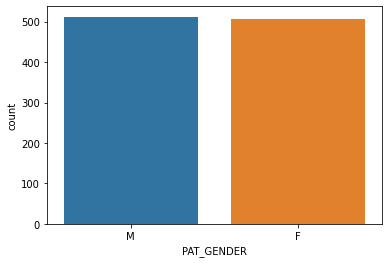

In [41]:
sns.countplot(x="PAT_GENDER", data=df)

Ausgeglichene Anzahl von weiblichen und männlichen Patienten.

## Säulendiagramm "Diagnosen"

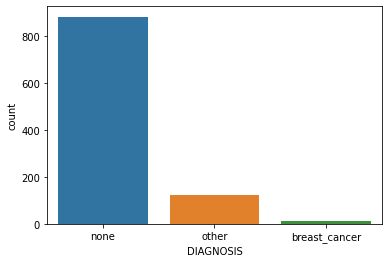

In [42]:
sns.countplot(x="DIAGNOSIS", data=df)

Bei den meisten Patienten wurde keine Diagnose gestellt (none). Bei ca.150 Patienten wurde eine Diagnose gestellt, die aber nicht Brustkrebs war. Und nur bei sehr wenigen Patienten ergab sich die Diagnose Brustkrebs.

## Säulendiagramm "Ethnicity"

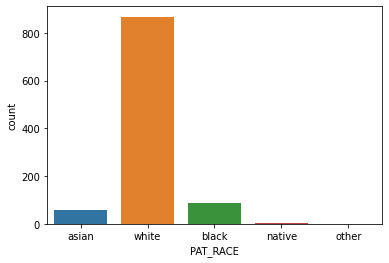

In [43]:
sns.countplot(x="PAT_RACE", data=df)

Dieses Säulendiagramm zeigt, dass die meisten Patienten kaukasischer Abstammung waren. Andere Ethnien kamen nur in Ausnahmefällen vor. (Es müsste hier eine Normalisierung stattfinden, d.h. die gesamte Anzahl der Personen unterschiedlicher Ethnien müsste mit dem Patientenklientel verglichen werden.) 

## Ausgaben für Medikamente für die unterschiedlichen Diagnosen

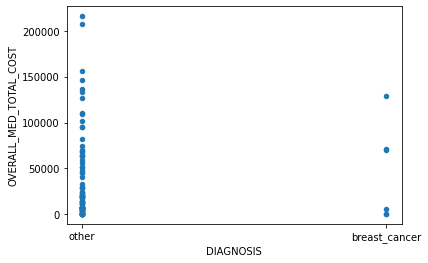

In [47]:
df.plot(kind='scatter', y = ('OVERALL_MED_TOTAL_COST'), x='DIAGNOSIS')

Die Analyse der Ausgaben für Medikamente lassen keine Aussagen zu, um welche Diagnose es sich handelt.

## Berechnung der Kosten, die die Patienten mit den verschiedenen Diagnosen selbst tragen müssen.

Hier eine Aufstellung wieviel die Medikamente insgesamt kosten und welcher Anteil von der Versicherung übernommen wird.

In [48]:
df.groupby('DIAGNOSIS')['OVERALL_MED_TOTAL_COST', 'OVERALL_MED_PAYER_COVERAGE'].mean()

<ipython-input-48-871ff73b6c82>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby('DIAGNOSIS')['OVERALL_MED_TOTAL_COST', 'OVERALL_MED_PAYER_COVERAGE'].mean()


,OVERALL_MED_TOTAL_COST,OVERALL_MED_PAYER_COVERAGE
DIAGNOSIS,,
breast_cancer,46030.308333,0.000000
none,NaN,NaN
other,35100.145000,933.639891


Hier eine Aufstellung wieviel die Arztbesuche insgesamt kosten und wieviel von den Versicherungen übernommen wird.

In [49]:
df.groupby('DIAGNOSIS')['OVERALL_ENC_BASE_COST', 'OVERALL_ENC_PAYER_COVERAGE'].mean()

<ipython-input-49-55b4a751457e>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby('DIAGNOSIS')['OVERALL_ENC_BASE_COST', 'OVERALL_ENC_PAYER_COVERAGE'].mean()


,OVERALL_ENC_BASE_COST,OVERALL_ENC_PAYER_COVERAGE
DIAGNOSIS,,
breast_cancer,6305.258182,2990.123636
none,980.973122,908.649367
other,1333.264516,1126.682903


In [50]:
groupby_obj = df.groupby('DIAGNOSIS')

In [51]:
groupby_obj.mean()

,OVERALL_ENC_BASE_COST,OVERALL_ENC_PAYER_COVERAGE,NUMBER_ENCOUNTERS,OVERALL_PRO_BASE_COST,NUMBER_PROCEDURES,OVERALL_MED_BASE_COST,OVERALL_MED_DISPENSES,OVERALL_MED_TOTAL_COST,OVERALL_MED_PAYER_COVERAGE,NUMBER_MEDICATIONS
DIAGNOSIS,,,,,,,,,,
breast_cancer,6305.258182,2990.123636,55.363636,129269.329091,42.545455,27832.935000,233.666667,46030.308333,0.000000,5.818182
none,980.973122,908.649367,7.595023,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000
other,1333.264516,1126.682903,10.322581,96145.761212,2.241935,1551.801957,418.717391,35100.145000,933.639891,2.927419


Berechnung wieviel der Kosten der Patient selber tragen muss (Medikamente und Arztbesuche)

In [52]:
df.eval('PATIENT_COST = (OVERALL_ENC_BASE_COST - OVERALL_ENC_PAYER_COVERAGE) + (OVERALL_MED_TOTAL_COST - OVERALL_MED_PAYER_COVERAGE)', inplace = True)
df.columns

Index(['PATIENT', 'PAT_GENDER', 'PAT_RACE', 'DIAGNOSIS',
       'OVERALL_ENC_BASE_COST', 'OVERALL_ENC_PAYER_COVERAGE',
       'NUMBER_ENCOUNTERS', 'OVERALL_PRO_BASE_COST', 'NUMBER_PROCEDURES',
       'OVERALL_MED_BASE_COST', 'OVERALL_MED_DISPENSES',
       'OVERALL_MED_TOTAL_COST', 'OVERALL_MED_PAYER_COVERAGE',
       'NUMBER_MEDICATIONS', 'PATIENT_COST'],
      dtype='object')

In [53]:
groupby_obj = df.groupby('DIAGNOSIS')

In [54]:
groupby_obj.mean()

,OVERALL_ENC_BASE_COST,OVERALL_ENC_PAYER_COVERAGE,NUMBER_ENCOUNTERS,OVERALL_PRO_BASE_COST,NUMBER_PROCEDURES,OVERALL_MED_BASE_COST,OVERALL_MED_DISPENSES,OVERALL_MED_TOTAL_COST,OVERALL_MED_PAYER_COVERAGE,NUMBER_MEDICATIONS,PATIENT_COST
DIAGNOSIS,,,,,,,,,,,
breast_cancer,6305.258182,2990.123636,55.363636,129269.329091,42.545455,27832.935000,233.666667,46030.308333,0.000000,5.818182,50470.145000
none,980.973122,908.649367,7.595023,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN
other,1333.264516,1126.682903,10.322581,96145.761212,2.241935,1551.801957,418.717391,35100.145000,933.639891,2.927419,34397.559891


In [55]:
df_cost = df[['PATIENT_COST', 'DIAGNOSIS']]

In [56]:
df_cost.head()

,PATIENT_COST,DIAGNOSIS
0,NaN,none
1,NaN,none
2,NaN,none
3,NaN,none
4,NaN,none


In [57]:
groupby_obj = df_cost.groupby('DIAGNOSIS')

In [58]:
groupby_obj.mean()

,PATIENT_COST
DIAGNOSIS,
breast_cancer,50470.145000
none,NaN
other,34397.559891


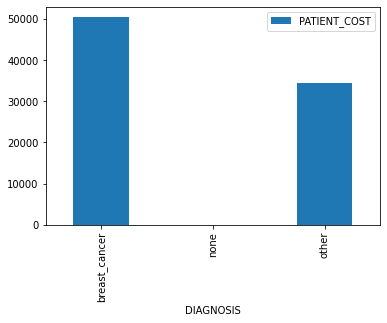

In [59]:
groupby_obj.mean().plot(kind='bar')

Die Analyse zeigt, dass Patienten mit Brutkrebs deutlich mehr Kosten selber tragen müssen, als Patienten mit einer anderen Diagnose oder gar keiner Diagnose.

In [60]:
df_encounters = df[[ 'DIAGNOSIS', 'NUMBER_ENCOUNTERS']]

In [61]:
df_encounters.head()

,DIAGNOSIS,NUMBER_ENCOUNTERS
0,none,4
1,none,5
2,none,6
3,none,8
4,none,9


In [62]:
groupby_obj = df_encounters.groupby('DIAGNOSIS')

In [63]:
groupby_obj.mean()

,NUMBER_ENCOUNTERS
DIAGNOSIS,
breast_cancer,55.363636
none,7.595023
other,10.322581


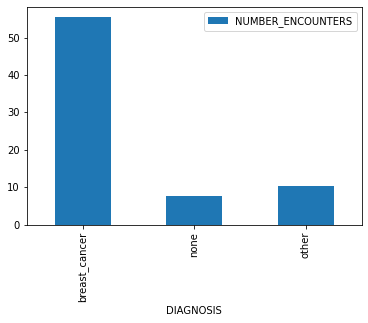

In [64]:
groupby_obj.mean().plot(kind='bar')

Die Analyse zeigt, dass Patienten mit Brustkrebs deutlich öfter den Arzt/ein Krankenhaus aufsuchen als Patienten mit einer anderen oder gar keiner Diagnose.

## Machine Learning

###Anhand der Kosten, die für den Patienten entstehen und der Anzahl der Arztbesuche soll auf die Diagnose der einzelnen Patienten geschlossen werden.

In [65]:
df_ml = df[['DIAGNOSIS', 'NUMBER_ENCOUNTERS', 'PATIENT_COST']]

In [66]:
df_ml.head()

,DIAGNOSIS,NUMBER_ENCOUNTERS,PATIENT_COST
0,none,4,NaN
1,none,5,NaN
2,none,6,NaN
3,none,8,NaN
4,none,9,NaN


In [67]:
df_ml.groupby('DIAGNOSIS')

In [68]:
df_ml.groupby('DIAGNOSIS').head()

,DIAGNOSIS,NUMBER_ENCOUNTERS,PATIENT_COST
0,none,4,NaN
1,none,5,NaN
2,none,6,NaN
3,none,8,NaN
4,none,9,NaN
11,other,11,NaN
27,other,11,186.52
31,other,11,95318.00
37,breast_cancer,44,NaN
47,breast_cancer,40,NaN


In [69]:
# entfernen von NaNs
df_rest = df_ml.dropna(axis=0)

In [70]:
df_rest.head()

,DIAGNOSIS,NUMBER_ENCOUNTERS,PATIENT_COST
27,other,11,186.52
31,other,11,95318.00
67,other,12,20433.02
98,other,11,126633.09
113,other,13,29597.71


## Aufgrund der geringen Anzahl an vollständigen Datensätzen wird zunächst ein Decision Tree Modell versucht

In [71]:
# Importing the required packages 
import numpy as np 
import pandas as pd 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

# Suppress warnings 
# (sometimes you might want to ignore warnings, that's how you can achieve this)
import warnings
warnings.filterwarnings('ignore')


In [72]:
# Defining X and y
features = df_rest.columns.tolist()
features.remove('DIAGNOSIS')
X = df_rest[features]
y = df_rest.DIAGNOSIS

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=150, shuffle=True)

# Check the shape of the data sets
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (68, 2)
y_train: (68,)
X_test: (30, 2)
y_test: (30,)


Es stehen 68 vollständige Trainingsdatensätze und 30 vollständige Testdatensätze zur Verfügung.

Training eines Decision Trees mit dem gini-Index:

In [73]:
# Creating the classifier object 
clf_gini = DecisionTreeClassifier(criterion = "gini", 
            max_depth=3, min_samples_leaf=5) 
# Performing training 
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=5)

Vorhersage der Diagnose anhand der Testdaten:

In [74]:
 # Predicton on test with giniIndex 
y_pred = clf_gini.predict(X_test) 
print("Predicted values:\n") 
print(y_pred)

Predicted values:

['other' 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other'
 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other'
 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other'
 'other' 'other' 'other']


Darstellung der Konfusionsmatrix und der Accuracy:

In [75]:
print("-----"*15)
print("Confusion Matrix: \n", 
confusion_matrix(y_test, y_pred)) 

print("-----"*15)
print ("Accuracy : \n", 
accuracy_score(y_test,y_pred)*100) 
    
print("-----"*15)
print("Report : \n", 
classification_report(y_test, y_pred))

---------------------------------------------------------------------------
Confusion Matrix: 
 [[ 0  4]
 [ 0 26]]
---------------------------------------------------------------------------
Accuracy : 
 86.66666666666667
---------------------------------------------------------------------------
Report : 
                precision    recall  f1-score   support

breast_cancer       0.00      0.00      0.00         4
        other       0.87      1.00      0.93        26

     accuracy                           0.87        30
    macro avg       0.43      0.50      0.46        30
 weighted avg       0.75      0.87      0.80        30



Graphische Darstellung der Konfusionsmatrix:

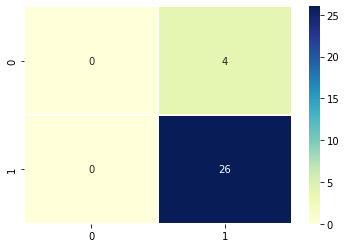

In [76]:
# Evaluate the model with a confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

Im vorliegenden Modell wurden die Patienten mit Brustkrebs nicht erkannt. Eine Erklärung dafür ist, dass sich alle Patienten mit Brustkrebs im Testset befanden. Da keine Brustkrebs-Patienten im Trainingsset vorhanden waren, konnte das Modell diese Diagnose nicht "lernen" und hat sie daher auch nicht erkannt.

## Ein weiterer Machine Learning Ansatz mit Hilfe einer Logistic Regression Analyse

In [77]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (11, 7)

Aufteilung in Trainings- und Testdaten sowie Training des Modells
Weiterhin graphische Darstellung der Konfusionsmatrix und der Accuracy.

Accuracy on train set: 1.0
Accuracy on test set: 0.97
--------------------------------------------------------------------------------
               precision    recall  f1-score   support

breast_cancer       1.00      0.75      0.86         4
        other       0.96      1.00      0.98        26

     accuracy                           0.97        30
    macro avg       0.98      0.88      0.92        30
 weighted avg       0.97      0.97      0.96        30

--------------------------------------------------------------------------------


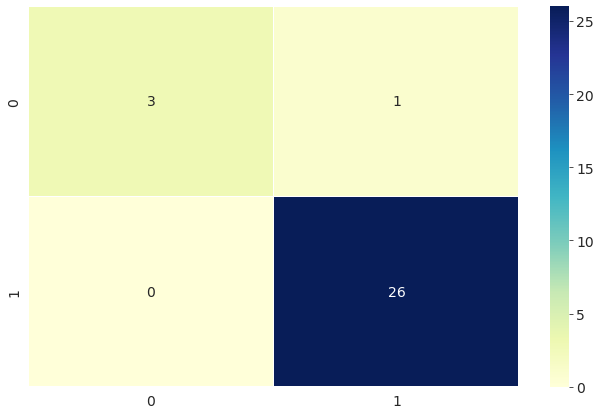

In [78]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred_train = log_reg.predict(X_train)
y_pred = log_reg.predict(X_test)

# Print accuracy of our model
print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_train), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred), 2))
print("--------"*10)

# Print classification report of our model
print(classification_report(y_test, y_pred))
print("--------"*10)

# Evaluate the model with a confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

Mit diesem Ansatz wurden 3 der 4 Brustkrebspatienten erkannt. Das Modell konnte die Diagnose mithilfe des Trainingssets lernen. Die Aufteilung in Trainings- und Testset war in diesem Ansatz ausgeglichener.

Aufgrund der geringen Fallzahlen sind die Ergebnisse dieser Modelle nicht belastbar. Für eine aussagekräftige Analyse ist es notwendig das Patientenkollektiv deutlich zu vergrößern.